In [ ]:
# Desafio DIO - módulo MD-07
# deesenvolver um modelo capaz de classificar imagens por sua similaridade e gerar resultados para o usuário de um site
# principais biblioteas utilizadas: Torch, openCV, pandas numpy, matplotlib, scikitlearn, entre outras
# como medida de similaridade foi utilizada Cosine metrics
# base de dados utilizada foi do Kaggle 'fashion products small'
# como referência de software foi utilizado o capítulo 5 do livro 'Computer Vison Projects with PyTorch', autores:
# Akshay Kulkarni, Adarsha Shivananda, Nitin Ranjan Sharma. ref: https://github.com/Apress/computer-vision-projects-with-pytorch
# ao final encontra-se o 'environment' utilizado neste desafio.

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import joblib
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from pandas.core.common import flatten
#TORCH
import torch
import torch.nn as nn
#modelos CV
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
#Pillow - imagems
from PIL import Image
# desativa mensagens de 'aviso'
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importa styles.csv como dataframe do pandas. 
# Colunas: id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
# Usando "on_bad_lines='skip'" para evitar de ler linhas com erro, embora eu já tenha corrigido várias

df = pd.read_csv('DIO_FashionSmall/styles.csv',on_bad_lines='skip')
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44446 non-null  int64  
 1   gender              44446 non-null  object 
 2   masterCategory      44446 non-null  object 
 3   subCategory         44446 non-null  object 
 4   articleType         44446 non-null  object 
 5   baseColour          44431 non-null  object 
 6   season              44425 non-null  object 
 7   year                44445 non-null  float64
 8   usage               44129 non-null  object 
 9   productDisplayName  44439 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [5]:
#modificando o estilo da plotagem para ggplot (do R)
plt.style.use('ggplot')

<Axes: ylabel='articleType'>

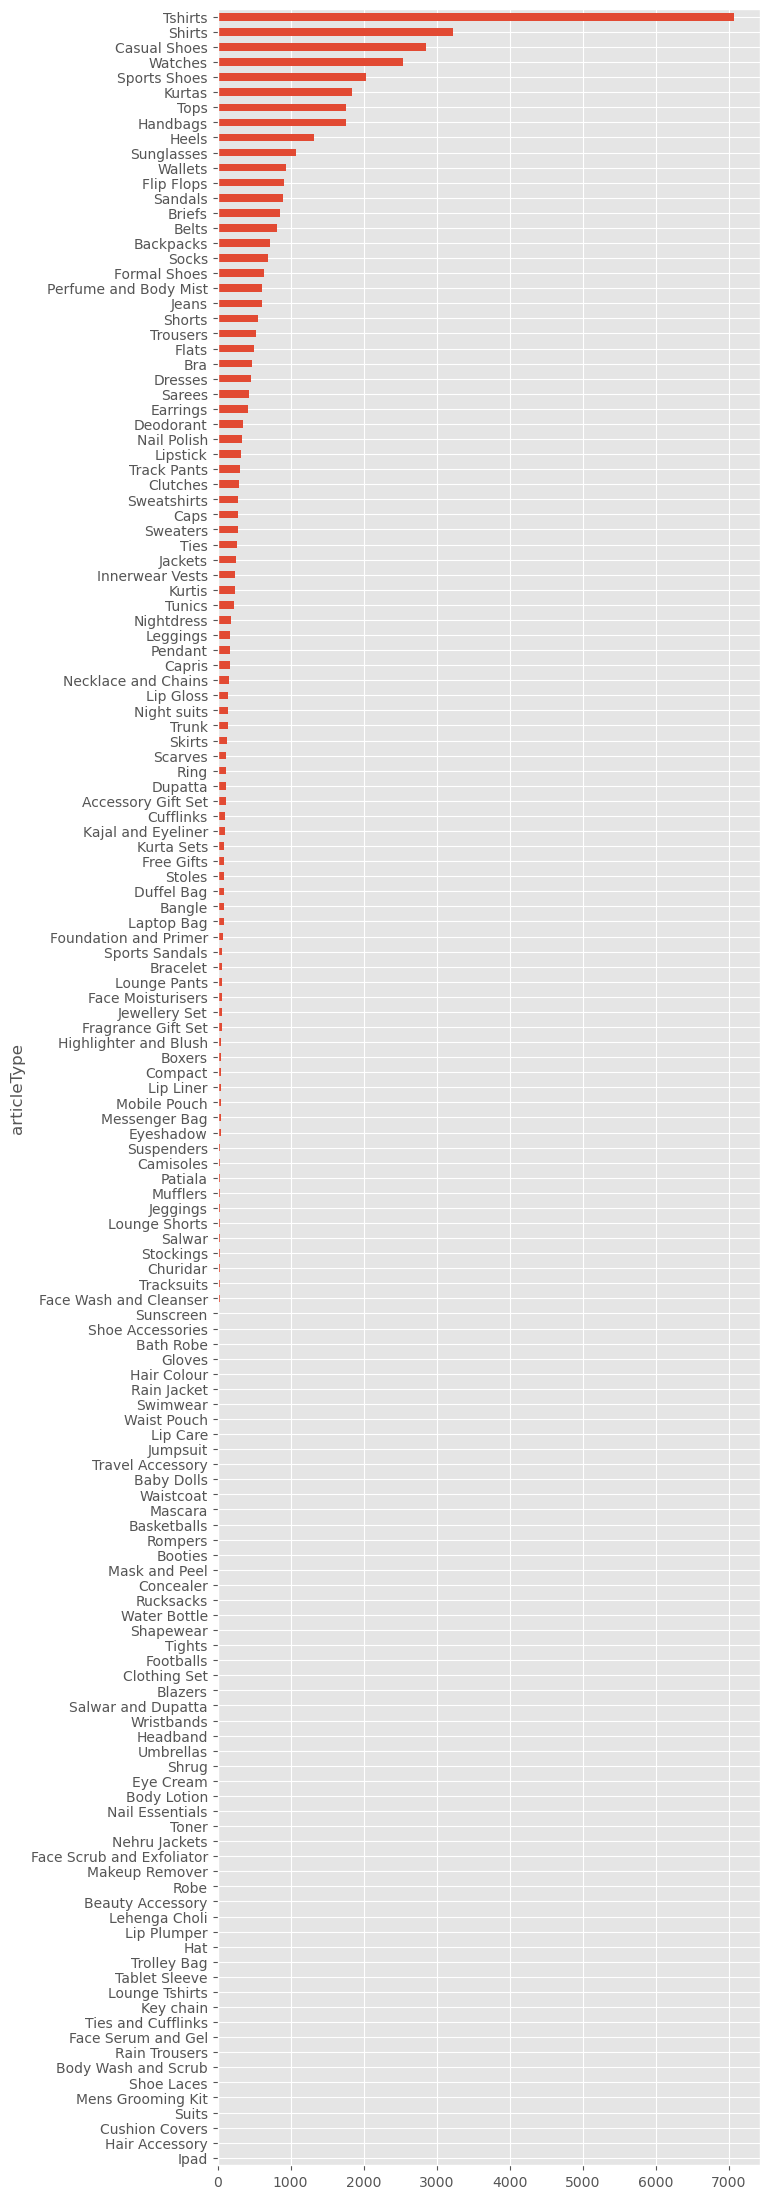

In [6]:
# verificando quantos tipos de artigos tem e quantidade
plt.figure(figsize=(7,28))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [7]:
# Cria nova coluna ('image') com nome da ID (id) do produto
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)

#reseting the index
df = df.reset_index(drop=True)

In [8]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [9]:
# funções para carregar imagem e plota-la
#caminho da imagem 
def image_location(img):
    return 'DIO_fashionSmall/images/'  + img

# carrega imagem
def import_img(image):
    image = cv2.imread(image_location(image))
    return image

In [10]:
def show_images(images, rows = 1, cols=1,figsize=(12, 12)):
    
    #define fig
    fig, axes = plt.subplots(ncols=cols, nrows=rows,figsize=figsize)
    
    #loop for images
    for index,name in enumerate(images):
        axes.ravel()[index].imshow(cv2.cvtColor(images[name], cv2.COLOR_BGR2RGB))
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
        
    #plot
    plt.tight_layout() 

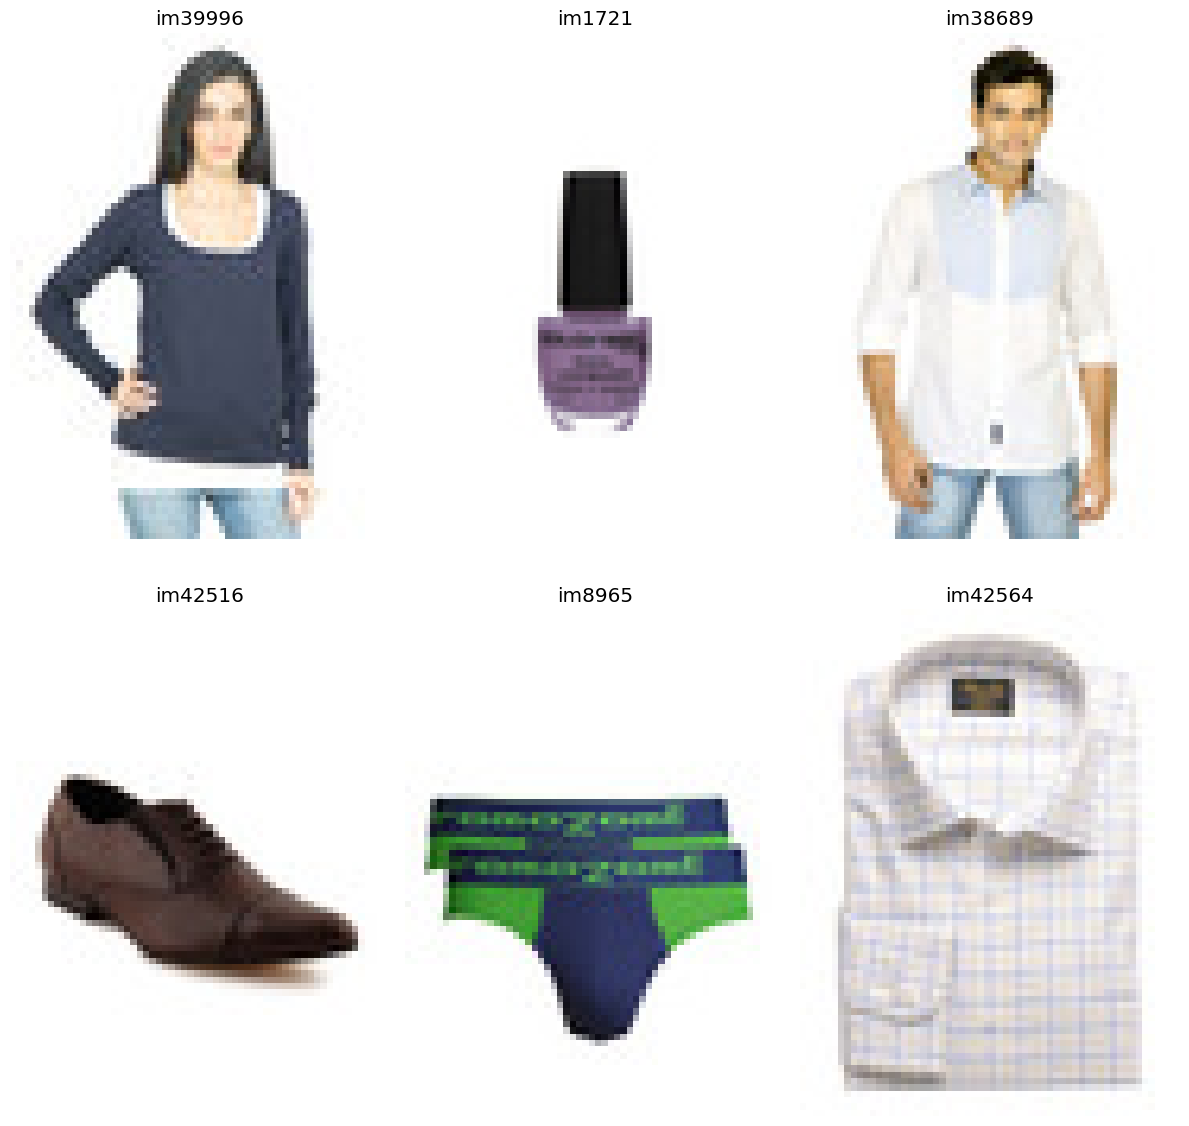

In [11]:
# cria dicionario {index, image}
figures = {'im'+str(i): import_img(row.image) for i, row in df.sample(6).iterrows()}

# display das imagens (6 de exemplo): 2 linhas e 3 colunas
show_images(figures, 2, 3)

In [12]:
# criando modelo
# definindo 'input' (dimensoes)
width= 224
height= 224

# carregando modelo pré-treinado
resnetmodel = models.resnet18(pretrained=True)

# selecionando a camada top
layer = resnetmodel._modules.get('avgpool')

In [13]:
#analisando modelo
resnetmodel.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# aplicando embeddings ao dataset
# redimensionando
from torchvision.transforms import v2
s_data = v2.Resize((224, 224))

#normalizandp
standardize = v2.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# convertendo em tensor
# convert_tensor = transforms.ToTensor() <- deprecated
convert_tensor = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

In [15]:
# se faltar imagem, será utilizado abaixo, no try/except
missing_img = []

In [16]:
#função para extrair embeddings

def vector_extraction(resnetmodel, image_id):
    
    # se houver imagens faltando controla o erro (try/except)
    try: 
        img = Image.open(image_location(image_id)).convert('RGB')
        
        t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
        embeddings = torch.zeros(512)
        
        def copy_data(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))
            
        hlayer = layer.register_forward_hook(copy_data)
        resnetmodel(t_img)
        hlayer.remove()
        emb = embeddings
        return embeddings
    
    # imagem não encontrada
    except FileNotFoundError:
        missed_img = df[df['image']==image_id].index
        print(missed_img)
        missing_img.append(missed_img)

In [17]:
# testa se vetor de extração funciona com imagem teste
sample_embedding_0 = vector_extraction(resnetmodel, df.iloc[0].image)

(80, 60, 3)
tensor([1.6732e-02, 9.8327e-01, 4.0268e-02, 1.1314e-01, 2.0513e-01, 1.2468e+00,
        3.5904e-02, 3.3680e-01, 1.3279e+00, 4.8053e-01, 4.5403e-02, 2.1866e-01,
        1.2002e+00, 1.2201e-01, 0.0000e+00, 9.9962e-03, 5.6686e-01, 0.0000e+00,
        1.9427e-02, 2.7316e-01, 2.9556e-01, 1.0254e+00, 1.1648e+00, 5.4014e-01,
        2.9776e-02, 1.2624e-01, 5.3572e-01, 2.1451e+00, 1.5348e-01, 3.6843e-01,
        1.1278e+00, 2.5455e-01, 2.3566e-01, 9.0818e-01, 1.4324e+00, 1.0864e+00,
        7.2151e-01, 2.8587e-01, 5.6683e-01, 7.9897e-02, 6.0556e-01, 6.3391e-02,
        2.2239e-01, 1.5460e+00, 2.6952e+00, 0.0000e+00, 4.6124e-02, 2.3474e-02,
        1.3130e+00, 5.5343e-01, 2.3303e+00, 3.7319e-01, 7.1914e-01, 4.4571e-01,
        8.5868e-01, 5.1455e-01, 4.8082e-01, 2.3485e+00, 4.6088e-01, 1.9201e+00,
        3.0348e-01, 7.3000e-01, 8.2374e-01, 5.0691e-01, 1.0031e-01, 3.2392e-02,
        5.1186e-01, 2.9504e-01, 1.7705e-01, 1.4258e+00, 4.5813e-01, 1.8374e+00,
        1.4661e-01, 6.7185e-

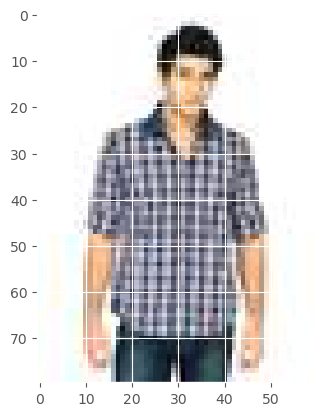

In [18]:
# plota imagem teste e embeddings
img_array = import_img(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(sample_embedding_0)

In [19]:
# testa se vetor de extração funciona com imagem teste
sample_embedding_1 = vector_extraction(resnetmodel, df.iloc[1000].image)

(80, 60, 3)
tensor([8.1168e-02, 5.7813e-01, 4.7128e-02, 2.8967e-01, 2.9504e-01, 1.4812e+00,
        2.8125e-02, 3.3850e-02, 1.0552e+00, 1.1357e-01, 6.4070e-01, 1.5981e-01,
        3.0579e-01, 2.2309e-01, 6.3423e-02, 4.7613e-01, 3.6778e-01, 5.3660e-03,
        0.0000e+00, 8.4447e-01, 2.3644e-01, 2.5653e-01, 9.0428e-01, 9.9996e-01,
        2.3291e-01, 4.8381e-01, 3.4912e-01, 2.7443e+00, 4.9957e-02, 9.0198e-01,
        7.1699e-01, 3.8131e-01, 7.1722e-02, 1.0567e+00, 1.6030e+00, 3.5465e-01,
        1.2334e+00, 5.1008e-01, 9.6673e-01, 3.0915e-01, 9.8764e-01, 6.1991e-02,
        3.9201e-01, 1.2598e+00, 1.3397e+00, 2.9732e-01, 9.2203e-02, 0.0000e+00,
        8.7319e-01, 6.4421e-01, 2.0365e+00, 3.8533e-01, 2.2168e-01, 4.7867e-01,
        1.9393e+00, 4.6684e-01, 1.6479e+00, 9.8806e-01, 5.5426e-02, 8.7997e-01,
        4.1201e-02, 7.4618e-01, 1.0865e+00, 6.6375e-01, 2.9428e-01, 2.7977e-01,
        4.4530e-01, 1.7650e-02, 4.8383e-01, 6.9452e-01, 1.1172e+00, 9.6705e-01,
        6.2011e-01, 2.1520e-

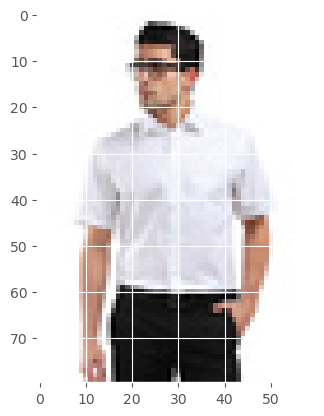

In [20]:
# plota resultado
img_array = import_img(df.iloc[1000].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(sample_embedding_1)

In [21]:
#procura similaridade entre duas imagens
cos_sim = cosine_similarity(sample_embedding_0.unsqueeze(0),
              sample_embedding_1.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))


Cosine similarity: [[0.88112545]]



In [22]:
%%time
import swifter
 
# aplicando embeddings em um subconjunto
df_embeddings     = df[:5000] #We can apply on entire df, like: df_embeddings = df

# pegando embeddings
map_embeddings = df_embeddings['image'].swifter.apply(lambda img: vector_extraction(resnetmodel, img))

#cconverte em séries
df_embs        = map_embeddings.apply(pd.Series)
print(df_embs.shape)
df_embs.head()

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 512)
CPU times: total: 18min 10s
Wall time: 2min 38s


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.016732,0.983268,0.040268,0.113140,0.205126,1.246755,0.035904,0.336804,1.327889,0.480528,...,0.584026,0.483293,1.229779,0.738920,0.00000,0.035314,1.740417,0.887333,0.004988,0.036427
1,0.034120,0.804465,0.071094,0.286109,0.118644,0.485674,0.767111,0.116924,1.131223,1.229429,...,0.125503,0.554488,0.160279,0.211642,0.00000,0.921633,1.210376,0.750110,0.015514,0.182356
2,0.306780,0.196792,2.325822,0.337868,0.206404,0.410260,2.865738,0.493550,2.894566,3.824194,...,0.377006,3.216576,2.293666,1.343939,1.04755,0.016881,2.759722,0.630299,0.114624,0.002224
3,0.052566,0.312827,0.318464,0.045759,0.207992,0.486138,0.871357,0.437959,0.861973,1.257671,...,0.000401,0.126219,0.117900,0.174460,0.00000,0.004943,1.039022,0.150582,0.009435,0.015909
4,0.146032,0.624985,0.023858,0.201499,0.273301,2.073839,0.038832,0.537267,1.338016,0.428539,...,0.039452,1.069758,0.774631,0.874319,0.00000,0.010583,2.638506,0.303629,0.005840,0.026666


In [23]:
#exporta embeddings 
df_embs.to_csv('df_embs.csv')


In [25]:
# calcula similaridade
cosine_sim = cosine_similarity(df_embs) 

# ver a estrutura do cosine 4x4
cosine_sim[:4, :4]

array([[1.0000006 , 0.76683563, 0.5455519 , 0.77950794],
       [0.76683563, 1.0000002 , 0.49617073, 0.8849271 ],
       [0.5455519 , 0.49617073, 0.99999976, 0.52310663],
       [0.77950794, 0.8849271 , 0.52310663, 1.0000012 ]], dtype=float32)

In [26]:
# Sarmazenar os indices em uma série
index_vales = pd.Series(range(len(df)), index=df.index)
index_vales

# função de recomendação baseada nas métricas de Cosine
def recomend_images(ImId, df, top_n = 6):
    
    # indice de referência sim_ImId
    sim_ImId    = index_vales[ImId]
    
    # armazenamento em uma lista de métricas de  cosine
    sim_scores = list(enumerate(cosine_sim[sim_ImId]))
    
    # sort das métricas
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # extração das 'top' métricas
    sim_scores = sim_scores[1:top_n+1]
    
    # retorna indice dos similares
    ImId_rec    = [i[0] for i in sim_scores]
    
    # retorna valor dos indices
    ImId_sim    = [i[1] for i in sim_scores]
    
    return index_vales.iloc[ImId_rec].index, ImId_sim

# Sample given below
recomend_images(3810, df, top_n = 5)

(Index([2400, 3899, 3678, 4818, 2354], dtype='int64'),
 [0.9632292, 0.9571409, 0.95574224, 0.9539636, 0.9537697])

In [27]:
# utiliza imagens do próprio banco de bados 'fashion products small', como imagem inicial para geral recomentações.
# aplicação seria oferecer outras opções similares exixtentes no estoque da empresa

def Rec_viz_image(input_imageid): 

    # Golhando recomentações
    idx_rec, idx_sim = recomend_images(input_imageid, df, top_n = 6)
    
    # imprimir métricas de similaridade
    print (idx_sim)
    
    # display da imiagem inicial (pesquisa do usuário)
    plt.imshow(cv2.cvtColor(import_img(df.iloc[input_imageid].image), cv2.COLOR_BGR2RGB))

    # gerar dicionário { index, image }
    figures = {'im'+str(i): import_img(row.image) for i, row in df.loc[idx_rec].iterrows()}
    
    # plotagem de imagens similares
    show_images(figures, 2, 3)
    

[0.9632292, 0.9571409, 0.95574224, 0.9539636, 0.9537697, 0.95369303]


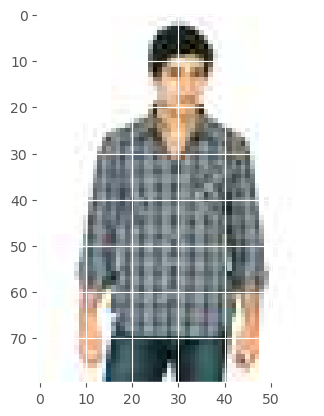

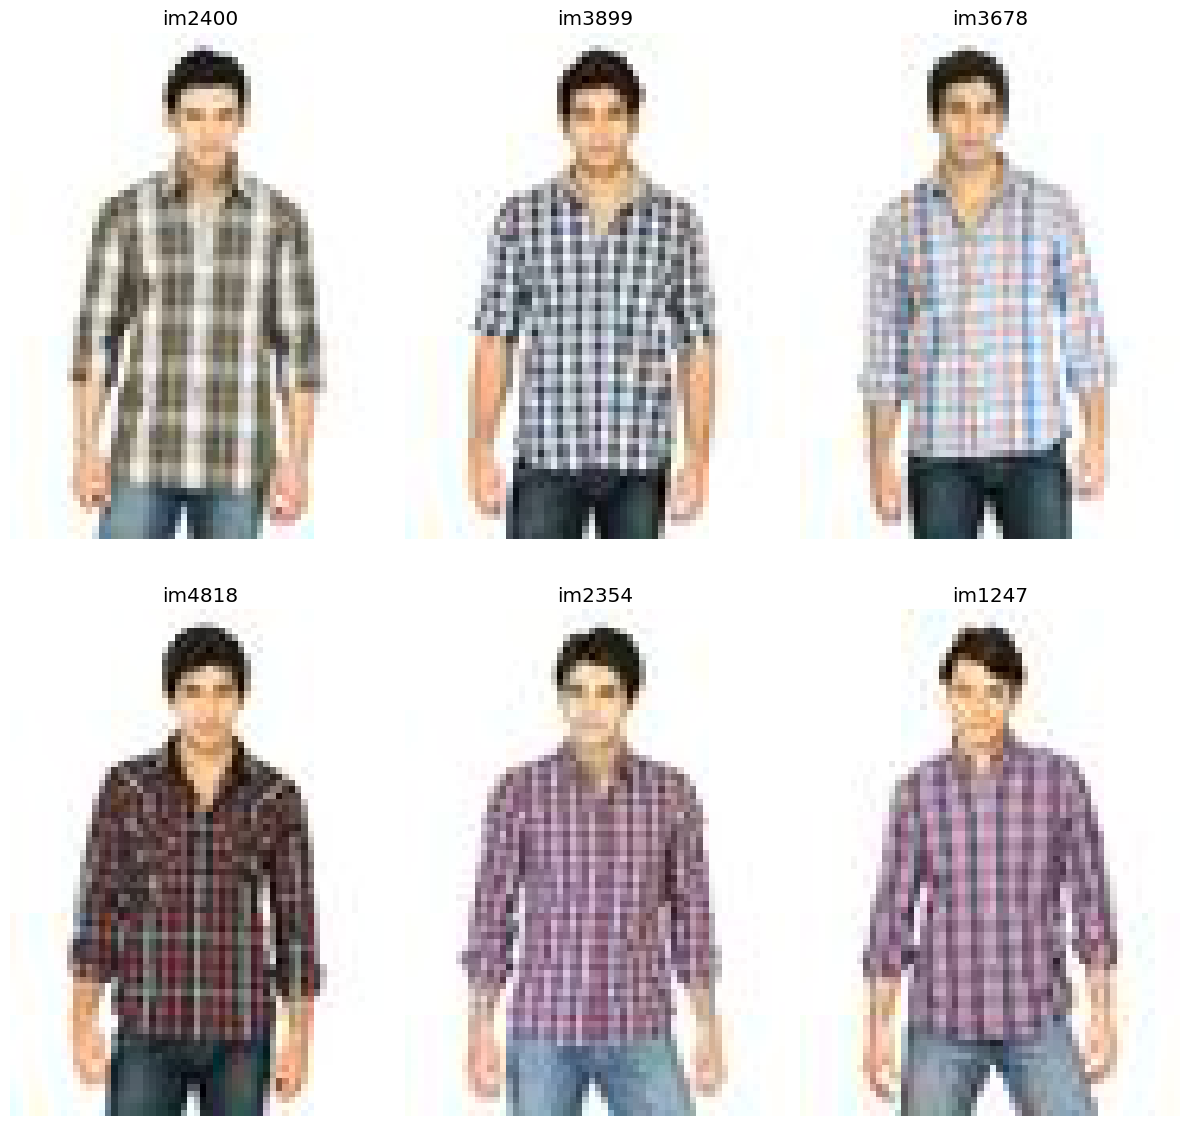

In [28]:
Rec_viz_image(3810)

[0.94663227, 0.94273365, 0.9418085, 0.9403438, 0.937523, 0.93717444]


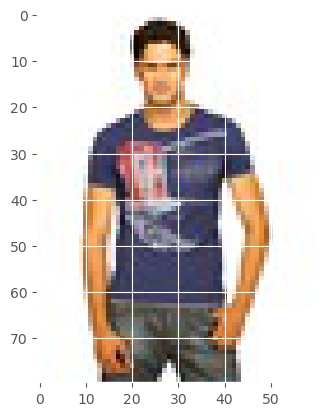

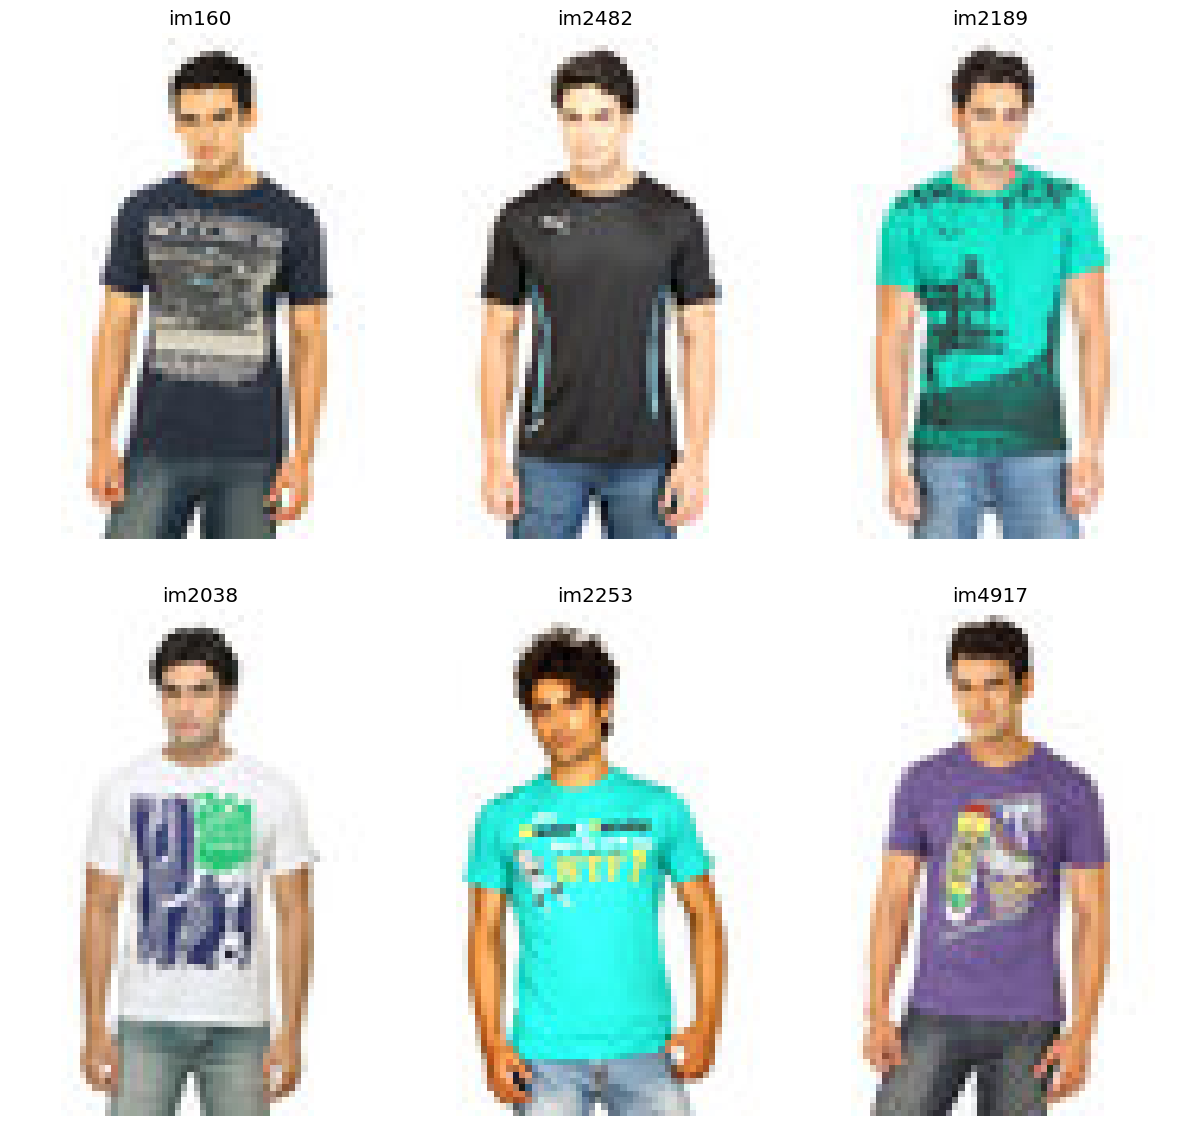

In [29]:
Rec_viz_image(1921)

[0.9506558, 0.931319, 0.92872155, 0.92470104, 0.92155343, 0.91743594]


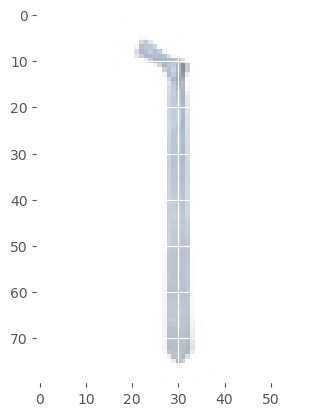

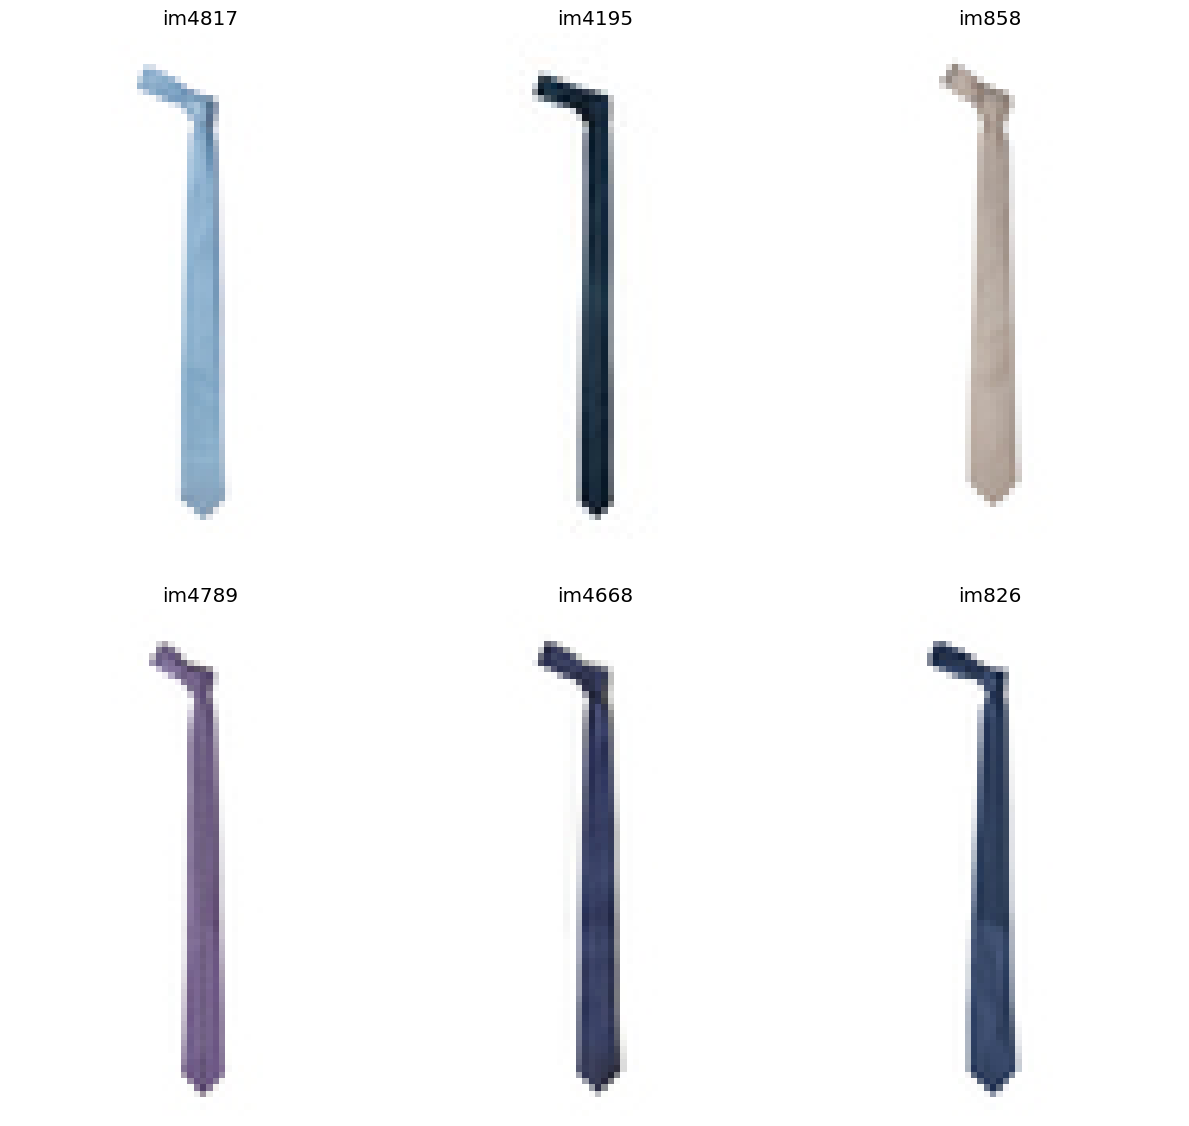

In [30]:
Rec_viz_image(2518)

[0.9653258, 0.94619274, 0.94110155, 0.93869746, 0.9379178, 0.9361303]


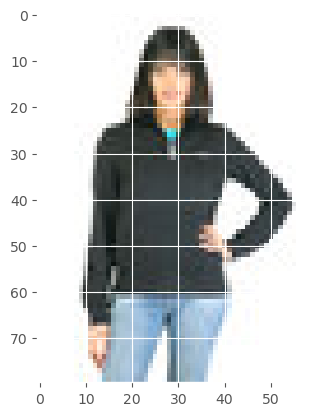

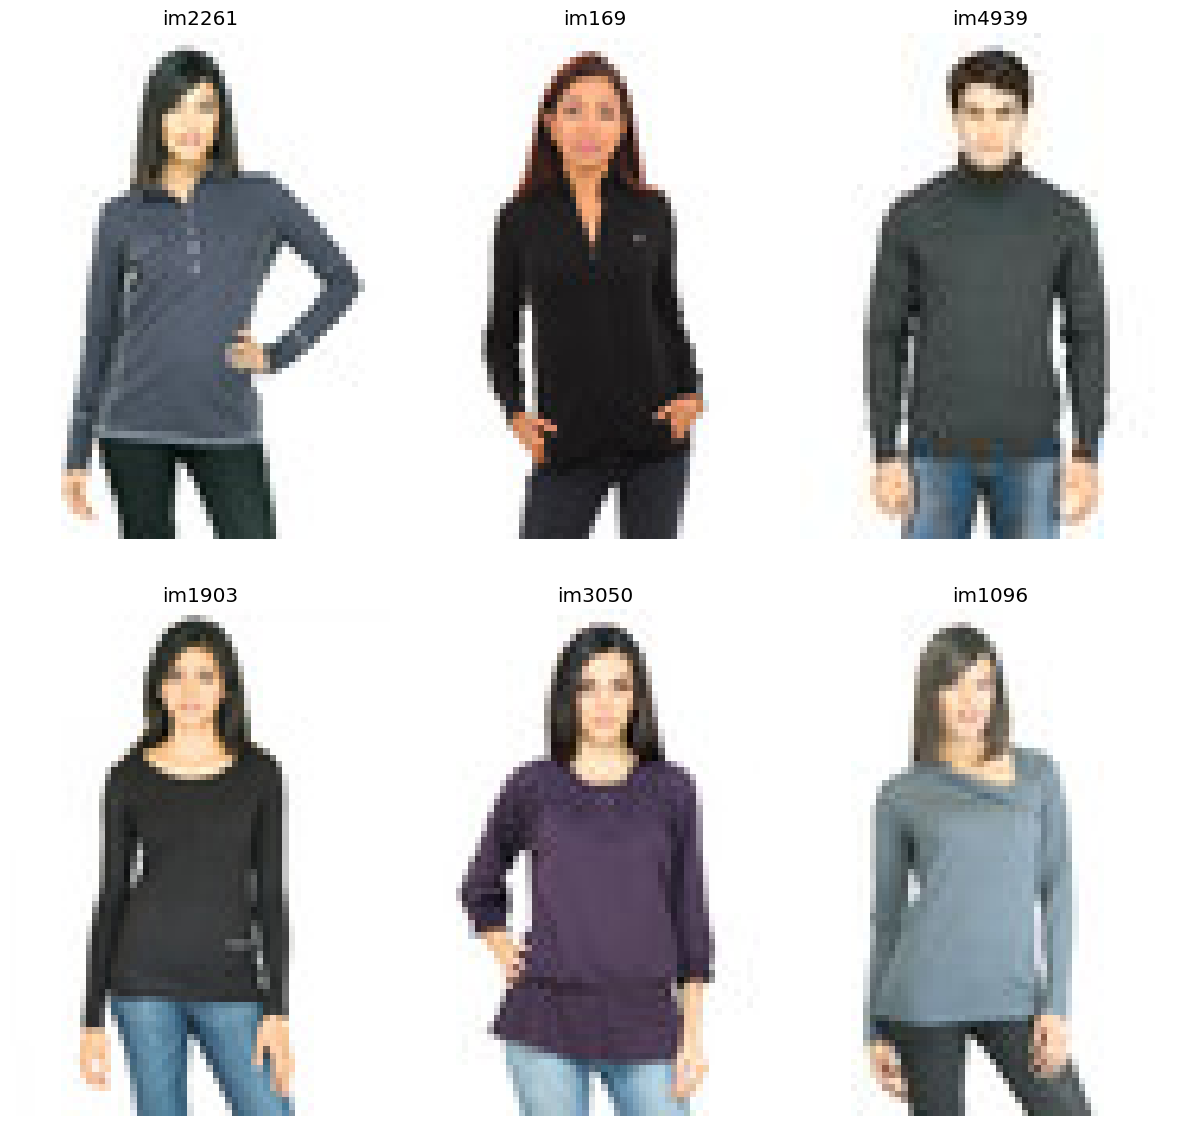

In [31]:
Rec_viz_image(1269)

[0.94526696, 0.94253445, 0.9389231, 0.9383375, 0.933819, 0.9322121]


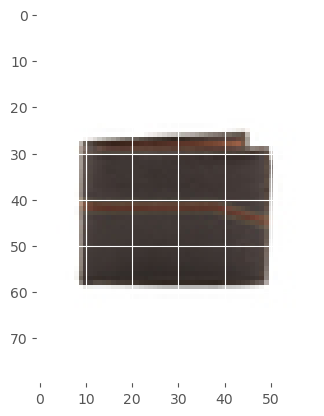

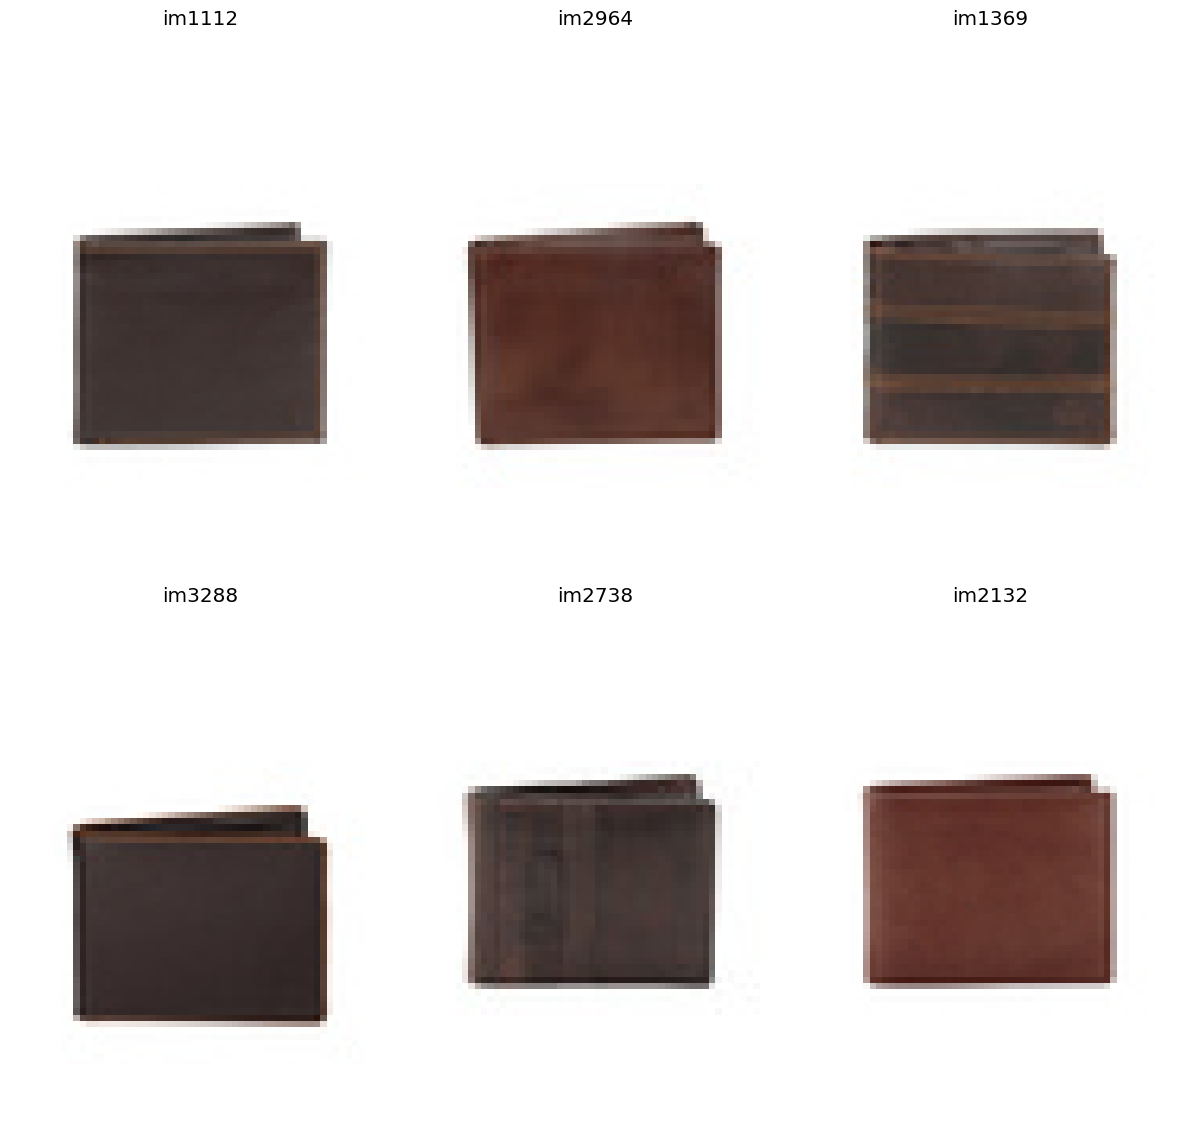

In [33]:
Rec_viz_image(2689)

[0.9726988, 0.9465236, 0.944247, 0.9418149, 0.9382514, 0.9371736]


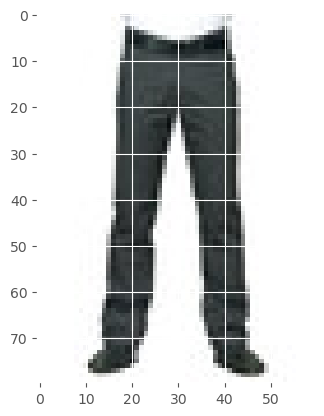

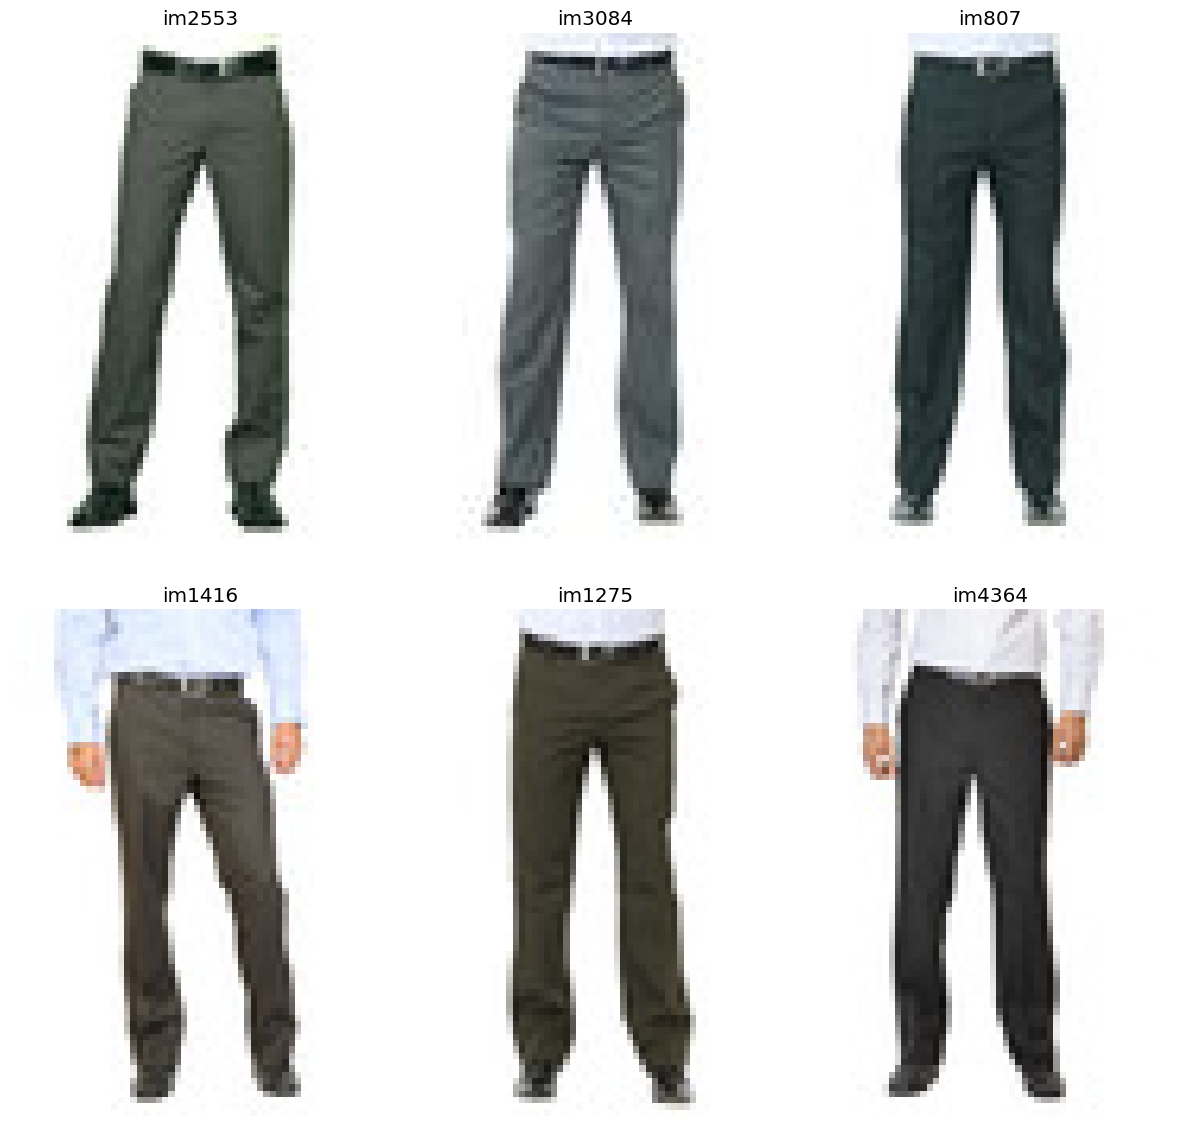

In [34]:
Rec_viz_image(2001)

4180    0.904605
3298    0.898086
2234    0.891339
1229    0.890777
62      0.885886
933     0.885638
2218    0.885364
311     0.885027
2560    0.884776
1179    0.883858
Name: Score, dtype: float32


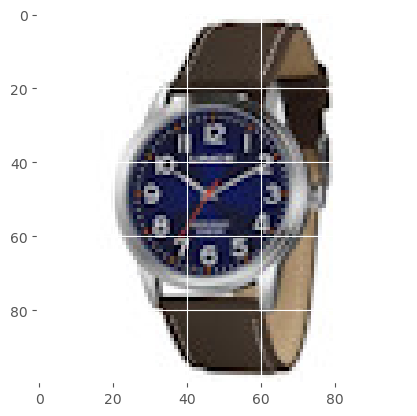

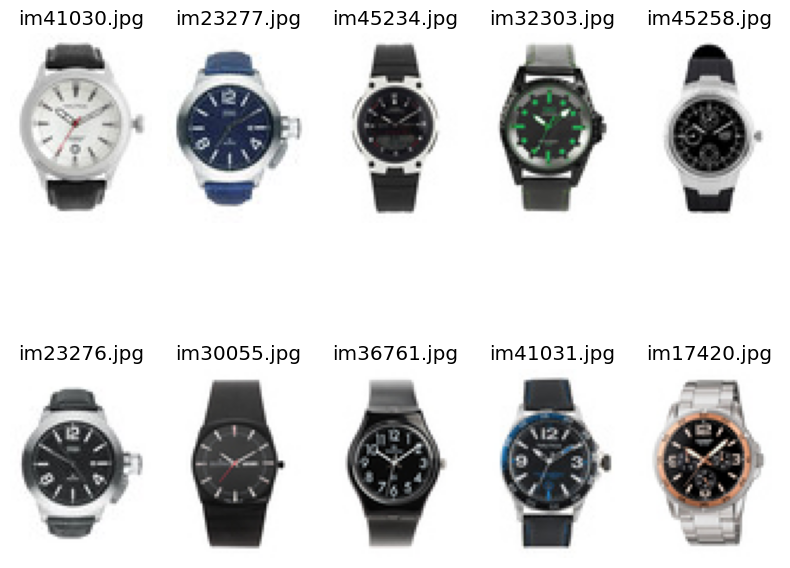

In [52]:
# utiliza imagem do usuário para fazer recomendações

def recm_user_input(image_id):
    image_ida =  image_id  
    # carrega imagem e dimensiona
    img = Image.open('DIO_fashionSmall/disco/imagens_teste/' + image_id).convert('RGB')
    
    # 2. cria varável do torch com imagem transformada
    t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
    
    # cria vetor de saída
    # camada 'avgpool' com saída 512
    embeddings = torch.zeros(512)
    
    # 4. defenindo funçã ode cópia da saída da camada
    def copy_data(m, i, o):
        embeddings.copy_(o.data.reshape(o.data.size(1)))
            
    # 5. adicionando função à camada 
    hlayer = layer.register_forward_hook(copy_data)
    
    # executando modelo
    resnetmodel(t_img)
    
    # remove função da camada
    hlayer.remove()
    emb = embeddings
    
    
    # calculando a métrica Cosine
    cs = cosine_similarity(emb.unsqueeze(0),df_embs)
    cs_list = list(flatten(cs))
    cs_df = pd.DataFrame(cs_list,columns=['Score'])
    cs_df = cs_df.sort_values(by=['Score'],ascending=False)
    
    # Printing Cosine Similarity
    print(cs_df['Score'][:10])
    
    # as imagens similares top 10
    top10 = cs_df[:10].index
    top10 = list(flatten(top10))
    images_list = []
    for i in top10:
        image_id = df[df.index==i]['image']
        images_list.append(image_id)

    reserva_img_list = images_list
        
    images_list = list(flatten(images_list))
    
    # dispaly da imagem inicial
    path = 'DIO_fashionSmall/disco/imagens_teste/' + image_ida
    img = cv2.imread(path)
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img2)
    plt.show()

    # criando um dicionário{ index, image }
    figures = {'im'+str(i): Image.open('DIO_fashionSmall/images/' + i) for i in images_list}
    
    # display das recomendações
    fig, axes = plt.subplots(2, 5, figsize = (8,8) )
    for index,name in enumerate(figures):
        axes.ravel()[index].imshow(figures[name])
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    plt.tight_layout() 

recm_user_input('relog-azul.jpg')


1333    0.924882
4947    0.922652
3044    0.918739
1376    0.915504
1118    0.915323
954     0.913843
1939    0.912578
4156    0.910050
125     0.909777
1822    0.909259
Name: Score, dtype: float32


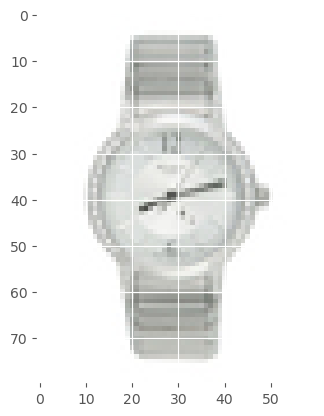

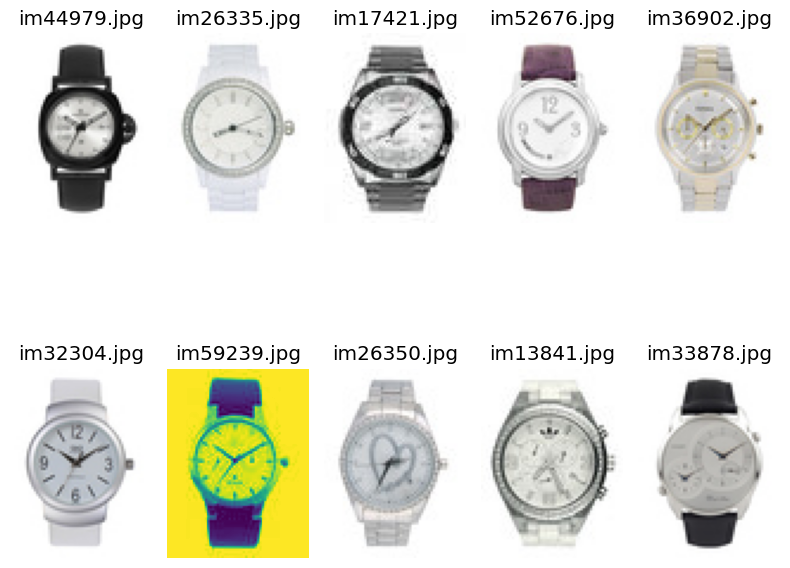

In [56]:
recm_user_input('test5.jpg')

2900    0.905992
4536    0.901253
125     0.897833
3299    0.896737
4564    0.896143
3380    0.894567
954     0.893068
4058    0.890203
4784    0.885361
2349    0.885248
Name: Score, dtype: float32


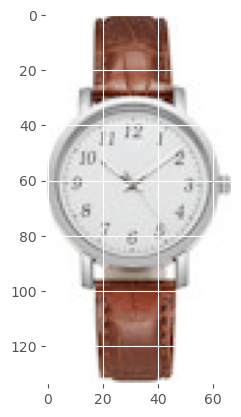

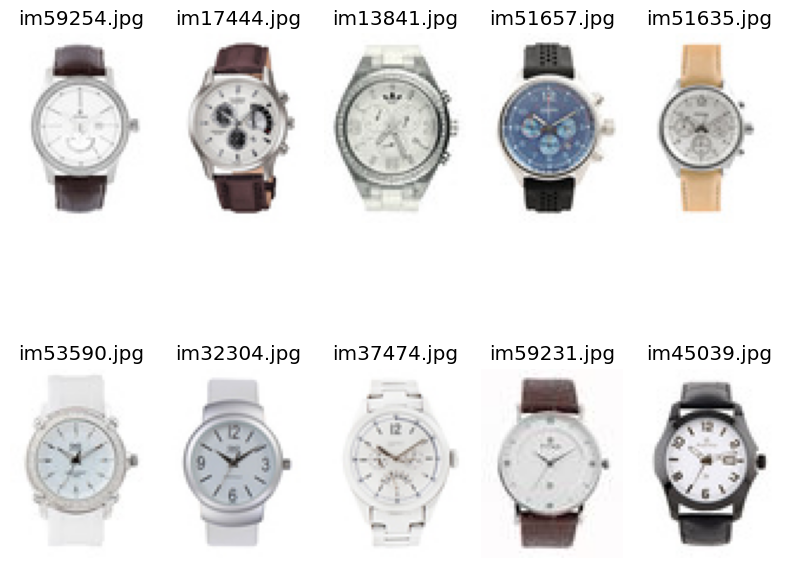

In [55]:
recm_user_input('relog-branco.jpg')

1968    0.852315
2701    0.820492
2400    0.820044
2032    0.820011
2590    0.818458
4541    0.817031
854     0.813446
2184    0.813441
4092    0.810835
4320    0.810099
Name: Score, dtype: float32


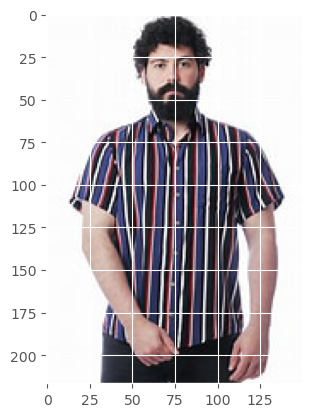

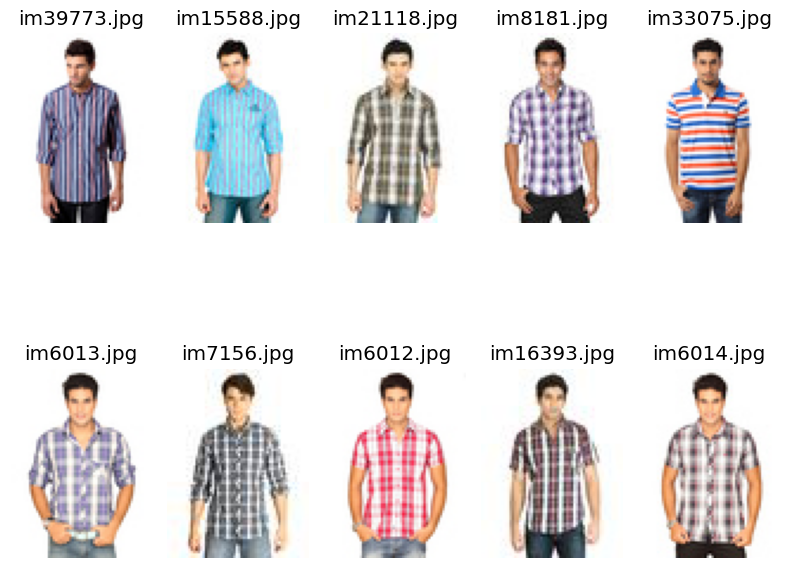

In [57]:
recm_user_input('camisa-listrada.jpg')

3290    0.832668
155     0.828529
71      0.819132
4747    0.810308
4396    0.808413
2114    0.806520
1396    0.805811
571     0.804309
2837    0.803709
627     0.802244
Name: Score, dtype: float32


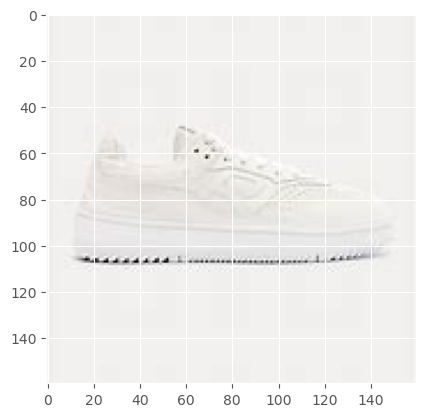

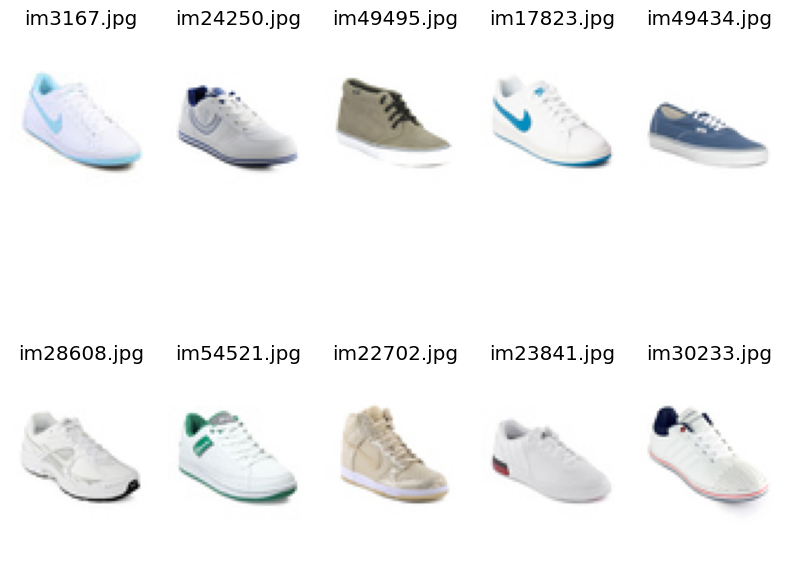

In [58]:
recm_user_input('tenis-branco.jpg')

In [ ]:
''' 
environment:

name: TorchCloneCV2
channels:
  - pytorch
  - nvidia
  - conda-forge
  - defaults
dependencies:
  - aiohappyeyeballs=2.4.0=py312haa95532_0
  - aiohttp=3.10.5=py312h827c3e9_0
  - aiosignal=1.2.0=pyhd3eb1b0_0
  - ansi2html=1.9.1=py312haa95532_0
  - arrow-cpp=16.1.0=h7cd61ee_0
  - asttokens=2.0.5=pyhd3eb1b0_0
  - attrs=23.1.0=py312haa95532_0
  - aws-c-auth=0.6.19=h2bbff1b_0
  - aws-c-cal=0.5.20=h2bbff1b_0
  - aws-c-common=0.8.5=h2bbff1b_0
  - aws-c-compression=0.2.16=h2bbff1b_0
  - aws-c-event-stream=0.2.15=hd77b12b_0
  - aws-c-http=0.6.25=h2bbff1b_0
  - aws-c-io=0.13.10=h2bbff1b_0
  - aws-c-mqtt=0.7.13=h2bbff1b_0
  - aws-c-s3=0.1.51=h2bbff1b_0
  - aws-c-sdkutils=0.1.6=h2bbff1b_0
  - aws-checksums=0.1.13=h2bbff1b_0
  - aws-crt-cpp=0.18.16=hd77b12b_0
  - aws-sdk-cpp=1.10.55=hd77b12b_0
  - blas=1.0=mkl
  - blinker=1.6.2=py312haa95532_0
  - bokeh=3.6.0=pyhd8ed1ab_0
  - boost-cpp=1.82.0=h59b6b97_2
  - bottleneck=1.3.7=py312he558020_0
  - brotli=1.0.9=h2bbff1b_8
  - brotli-bin=1.0.9=h2bbff1b_8
  - brotli-python=1.0.9=py312hd77b12b_8
  - bzip2=1.0.8=h2bbff1b_6
  - c-ares=1.19.1=h2bbff1b_0
  - ca-certificates=2024.12.14=h56e8100_0
  - cairo=1.16.0=hc68a040_5
  - certifi=2024.12.14=pyhd8ed1ab_0
  - charset-normalizer=3.3.2=pyhd3eb1b0_0
  - click=8.1.7=py312haa95532_0
  - cloudpickle=3.1.0=pyhd8ed1ab_2
  - colorama=0.4.6=py312haa95532_0
  - comm=0.2.1=py312haa95532_0
  - contourpy=1.2.0=py312h59b6b97_0
  - cuda-cccl=12.6.77=0
  - cuda-cccl_win-64=12.6.77=0
  - cuda-cudart=12.1.105=0
  - cuda-cudart-dev=12.1.105=0
  - cuda-cupti=12.1.105=0
  - cuda-libraries=12.1.0=0
  - cuda-libraries-dev=12.1.0=0
  - cuda-nvrtc=12.1.105=0
  - cuda-nvrtc-dev=12.1.105=0
  - cuda-nvtx=12.1.105=0
  - cuda-opencl=12.6.77=0
  - cuda-opencl-dev=12.6.77=0
  - cuda-profiler-api=12.6.77=0
  - cuda-runtime=12.1.0=0
  - cuda-version=12.6=3
  - cycler=0.11.0=pyhd3eb1b0_0
  - cytoolz=0.12.2=py312h2bbff1b_0
  - dash=2.14.2=py312haa95532_0
  - dask=2024.12.1=pyhd8ed1ab_0
  - dask-core=2024.12.1=pyhd8ed1ab_0
  - dask-expr=1.1.21=pyhd8ed1ab_0
  - datasets=2.19.1=py312haa95532_0
  - debugpy=1.6.7=py312hd77b12b_0
  - decorator=5.1.1=pyhd3eb1b0_0
  - dill=0.3.8=py312haa95532_0
  - distributed=2024.12.1=pyhd8ed1ab_0
  - eigen=3.4.0=h91493d7_0
  - executing=0.8.3=pyhd3eb1b0_0
  - expat=2.6.3=h5da7b33_0
  - filelock=3.13.1=py312haa95532_0
  - flask=3.0.3=py312haa95532_0
  - flask-compress=1.13=py312haa95532_0
  - flask-cors=3.0.10=pyhd3eb1b0_0
  - fontconfig=2.14.1=hb33846d_3
  - fonttools=4.51.0=py312h2bbff1b_0
  - freetype=2.12.1=ha860e81_0
  - frozenlist=1.4.0=py312h2bbff1b_0
  - fsspec=2024.3.1=py312haa95532_0
  - gflags=2.2.2=hd77b12b_1
  - glib=2.78.4=hd77b12b_0
  - glib-tools=2.78.4=hd77b12b_0
  - glog=0.5.0=hd77b12b_1
  - graphite2=1.3.14=hd77b12b_1
  - gst-plugins-base=1.22.3=hfc3ed34_1
  - gstreamer=1.22.3=h1779075_1
  - harfbuzz=4.3.0=hb646838_2
  - hdf5=1.12.1=h51c971a_3
  - huggingface_hub=0.24.6=py312haa95532_0
  - icc_rt=2022.1.0=h6049295_2
  - icu=73.1=h6c2663c_0
  - idna=3.7=py312haa95532_0
  - importlib-metadata=7.0.1=py312haa95532_0
  - intel-openmp=2023.1.0=h59b6b97_46320
  - ipykernel=6.29.5=py312haa95532_0
  - ipython=8.27.0=py312haa95532_0
  - ipywidgets=8.1.5=pyhd8ed1ab_0
  - itsdangerous=2.2.0=py312haa95532_0
  - jedi=0.19.1=py312haa95532_0
  - jinja2=3.1.4=py312haa95532_0
  - joblib=1.4.2=py312haa95532_0
  - jpeg=9e=h827c3e9_3
  - jupyter-dash=0.4.2=py312haa95532_0
  - jupyter_bokeh=4.0.5=pyhd8ed1ab_0
  - jupyter_client=8.6.0=py312haa95532_0
  - jupyter_core=5.7.2=py312haa95532_0
  - jupyterlab_widgets=3.0.13=pyhd8ed1ab_0
  - kiwisolver=1.4.4=py312hd77b12b_0
  - krb5=1.20.1=h5b6d351_0
  - lcms2=2.12=h83e58a3_0
  - lerc=3.0=hd77b12b_0
  - libabseil=20240116.2=cxx17_h5da7b33_0
  - libboost=1.82.0=h3399ecb_2
  - libbrotlicommon=1.0.9=h2bbff1b_8
  - libbrotlidec=1.0.9=h2bbff1b_8
  - libbrotlienc=1.0.9=h2bbff1b_8
  - libclang=14.0.6=default_hb5a9fac_1
  - libclang13=14.0.6=default_h8e68704_1
  - libcublas=12.1.0.26=0
  - libcublas-dev=12.1.0.26=0
  - libcufft=11.0.2.4=0
  - libcufft-dev=11.0.2.4=0
  - libcurand=10.3.7.77=0
  - libcurand-dev=10.3.7.77=0
  - libcurl=8.9.1=h0416ee5_0
  - libcusolver=11.4.4.55=0
  - libcusolver-dev=11.4.4.55=0
  - libcusparse=12.0.2.55=0
  - libcusparse-dev=12.0.2.55=0
  - libdeflate=1.17=h2bbff1b_1
  - libevent=2.1.12=h56d1f94_1
  - libffi=3.4.4=hd77b12b_1
  - libglib=2.78.4=ha17d25a_0
  - libgrpc=1.62.2=hf25190f_0
  - libiconv=1.17=hcfcfb64_2
  - libjpeg-turbo=2.0.0=h196d8e1_0
  - libnpp=12.0.2.50=0
  - libnpp-dev=12.0.2.50=0
  - libnvjitlink=12.1.105=0
  - libnvjitlink-dev=12.1.105=0
  - libnvjpeg=12.1.1.14=0
  - libnvjpeg-dev=12.1.1.14=0
  - libogg=1.3.5=h2466b09_0
  - libpng=1.6.39=h8cc25b3_0
  - libpq=12.17=h906ac69_0
  - libprotobuf=4.25.3=hf2fb9eb_0
  - libsodium=1.0.18=h62dcd97_0
  - libssh2=1.11.0=h291bd65_0
  - libthrift=0.15.0=h4364b78_2
  - libtiff=4.5.1=hd77b12b_0
  - libuv=1.48.0=h827c3e9_0
  - libvorbis=1.3.7=h0e60522_0
  - libwebp-base=1.3.2=h2bbff1b_0
  - libxml2=2.13.5=h24da03e_0
  - lightning-utilities=0.9.0=py312haa95532_0
  - locket=1.0.0=pyhd8ed1ab_0
  - lz4=4.3.2=py312h2bbff1b_0
  - lz4-c=1.9.4=h2bbff1b_1
  - markupsafe=2.1.3=py312h2bbff1b_0
  - matplotlib=3.9.2=py312haa95532_0
  - matplotlib-base=3.9.2=py312hbdc63d0_0
  - matplotlib-inline=0.1.6=py312haa95532_0
  - mkl=2023.1.0=h6b88ed4_46358
  - mkl-service=2.4.0=py312h2bbff1b_1
  - mkl_fft=1.3.10=py312h827c3e9_0
  - mkl_random=1.2.7=py312h0158946_0
  - mpmath=1.3.0=py312haa95532_0
  - msgpack-python=1.0.3=py312h59b6b97_0
  - multidict=6.0.4=py312h2bbff1b_0
  - multiprocess=0.70.15=py312haa95532_0
  - nest-asyncio=1.6.0=py312haa95532_0
  - networkx=3.3=py312haa95532_0
  - numexpr=2.8.7=py312h96b7d27_0
  - numpy=1.26.4=py312hfd52020_0
  - numpy-base=1.26.4=py312h4dde369_0
  - opencv=4.10.0=py312h4ccfa20_0
  - openjpeg=2.5.2=hae555c5_0
  - openssl=3.4.0=h2466b09_0
  - orc=2.0.1=hd8d391b_0
  - orjson=3.10.7=py312h827c3e9_0
  - packaging=24.1=py312haa95532_0
  - pandas=2.2.2=py312h0158946_0
  - parso=0.8.3=pyhd3eb1b0_0
  - partd=1.4.2=pyhd8ed1ab_0
  - patsy=0.5.6=py312haa95532_0
  - pcre2=10.42=h0ff8eda_1
  - pillow=11.0.0=py312hb5480e2_0
  - pip=24.2=py312haa95532_0
  - pixman=0.44.2=had0cd8c_0
  - platformdirs=3.10.0=py312haa95532_0
  - plotly=5.24.1=py312hfc267ef_0
  - plotly-resampler=0.8.3.2=py312he558020_3
  - ply=3.11=py312haa95532_1
  - prompt-toolkit=3.0.43=py312haa95532_0
  - prompt_toolkit=3.0.43=hd3eb1b0_0
  - protobuf=4.25.3=py312h958608f_0
  - psutil=5.9.0=py312h2bbff1b_0
  - pure_eval=0.2.2=pyhd3eb1b0_0
  - py-opencv=4.10.0=haa95532_0
  - pyarrow=16.1.0=py312h0158946_0
  - pybind11-abi=5=hd3eb1b0_0
  - pygments=2.15.1=py312haa95532_1
  - pyparsing=3.1.2=py312haa95532_0
  - pyqt=5.15.10=py312hd77b12b_0
  - pyqt5-sip=12.13.0=py312h2bbff1b_0
  - pysocks=1.7.1=py312haa95532_0
  - python=3.12.7=h14ffc60_0
  - python-dateutil=2.9.0post0=py312haa95532_2
  - python-tzdata=2023.3=pyhd3eb1b0_0
  - python-xxhash=2.0.2=py312h2bbff1b_1
  - pytorch=2.3.0=py3.12_cuda12.1_cudnn8_0
  - pytorch-cuda=12.1=hde6ce7c_5
  - pytorch-lightning=2.3.0=py312haa95532_0
  - pytorch-mutex=1.0=cuda
  - pytz=2024.1=py312haa95532_0
  - pywin32=305=py312h2bbff1b_0
  - pyyaml=6.0.2=py312h827c3e9_0
  - pyzmq=25.1.2=py312hd77b12b_0
  - qt-main=5.15.2=h19c9488_10
  - re2=2022.04.01=hd77b12b_0
  - regex=2024.9.11=py312h827c3e9_0
  - requests=2.32.3=py312haa95532_0
  - retrying=1.3.3=pyhd3eb1b0_2
  - safetensors=0.4.4=py312h1429478_0
  - scikit-learn=1.5.1=py312h0158946_0
  - scipy=1.13.1=py312hbb039d4_0
  - seaborn=0.13.2=py312haa95532_0
  - setuptools=75.1.0=py312haa95532_0
  - sip=6.7.12=py312hd77b12b_0
  - six=1.16.0=pyhd3eb1b0_1
  - snappy=1.2.1=hcdb6601_0
  - sortedcontainers=2.4.0=pyhd8ed1ab_0
  - sqlite=3.45.3=h2bbff1b_0
  - stack_data=0.2.0=pyhd3eb1b0_0
  - statsmodels=0.14.2=py312h4b0e54e_0
  - swifter=1.4.0=pyhd8ed1ab_1
  - sympy=1.13.2=py312haa95532_0
  - tbb=2021.8.0=h59b6b97_0
  - tblib=3.0.0=pyhd8ed1ab_1
  - tenacity=8.2.3=py312haa95532_0
  - tensorboardx=2.6.2.2=py312haa95532_0
  - threadpoolctl=3.5.0=py312hfc267ef_0
  - tk=8.6.14=h0416ee5_0
  - tokenizers=0.19.1=py312hc899e84_0
  - toolz=1.0.0=pyhd8ed1ab_1
  - torchmetrics=1.4.0.post0=py312haa95532_0
  - tornado=6.4.1=py312h827c3e9_0
  - tqdm=4.66.5=py312hfc267ef_0
  - trace-updater=0.0.9.1=py312haa95532_0
  - traitlets=5.14.3=py312haa95532_0
  - transformers=4.44.1=py312haa95532_0
  - typing-extensions=4.11.0=py312haa95532_0
  - typing_extensions=4.11.0=py312haa95532_0
  - tzdata=2024b=h04d1e81_0
  - ucrt=10.0.22621.0=h57928b3_1
  - unicodedata2=15.1.0=py312h2bbff1b_0
  - urllib3=2.2.3=py312haa95532_0
  - utf8proc=2.6.1=h2bbff1b_1
  - vc=14.40=h2eaa2aa_1
  - vc14_runtime=14.40.33810=hcc2c482_22
  - vs2015_runtime=14.40.33810=h3bf8584_22
  - wcwidth=0.2.5=pyhd3eb1b0_0
  - werkzeug=3.0.3=py312haa95532_0
  - wheel=0.44.0=py312haa95532_0
  - widgetsnbextension=4.0.13=pyhd8ed1ab_0
  - win_inet_pton=1.1.0=py312haa95532_0
  - xxhash=0.8.0=h2bbff1b_3
  - xyzservices=2024.9.0=pyhd8ed1ab_0
  - xz=5.4.6=h8cc25b3_1
  - yaml=0.2.5=he774522_0
  - yarl=1.11.0=py312h827c3e9_0
  - zeromq=4.3.5=hd77b12b_0
  - zict=3.0.0=pyhd8ed1ab_1
  - zipp=3.17.0=py312haa95532_0
  - zlib=1.2.13=h8cc25b3_1
  - zstd=1.5.6=h8880b57_0
  - pip:
      - torchaudio==2.3.0
      - torchvision==0.18.0
'''